In [1]:
import requests
from bs4 import BeautifulSoup
import re
import numpy as np
import pandas as pd
from openai import OpenAI
import os
import time
from collections import defaultdict
import datetime

# Get Text from URL Sources

In [2]:
# cleaning text

def clean_text(raw_text):
    text = raw_text.replace('\n', ' ')
    text = re.sub(r'-\s+', '', text)  # join hyphenated words
    text = re.sub(r'\s+', ' ', text).strip()
    text = text.replace('—', '-').replace('“', '"').replace('”', '"').replace("’", "'")
    text = re.sub(r'CHAPTER\s[\w\d\.]+.*?(?=\s)', '', text, flags=re.IGNORECASE)
    text = re.sub(r'^[A-Z\s\.,\'\-]{10,}$', '', text, flags=re.MULTILINE)
    return text

In [3]:
url = 'https://gutenberg.net.au/ebooks/e00052.html'

# Fetch the page content
response = requests.get(url)
response.raise_for_status()  # Ensure we notice bad responses

In [4]:
# Parse the HTML content
soup = BeautifulSoup(response.content, 'html.parser')

In [5]:
# Step 2: Traverse and collect content into books dict
books = {}
current_book = None

for tag in soup.find_all():
    # Detect start of a new book
    if tag.name == 'a' and tag.has_attr('name') and tag['name'].lower().startswith('book'):
        current_book = tag['name'].lower()
        books[current_book] = []

    # Collect paragraph/blockquote text
    if current_book and tag.name in ['p', 'blockquote']:
        text = tag.get_text(strip=True)
        if text:
            books[current_book].append(text)

In [6]:
def check_duplicates(book_dict):
    seen_texts = {}
    for book, paragraphs in book_dict.items():
        unique_paragraphs = set(paragraphs)
        seen_texts[book] = unique_paragraphs

    # Compare each pair of books
    for book1 in seen_texts:
        for book2 in seen_texts:
            if book1 >= book2:  # avoid duplicate comparisons
                continue
            intersection = seen_texts[book1] & seen_texts[book2]
            if intersection:
                print(f"⚠️ Duplicate content found between {book1} and {book2}: {len(intersection)} shared paragraphs")

check_duplicates(books)

In [7]:
for book, paras in books.items():
    print(f"{book}: {len(paras)} paragraphs")
    print(f"First: {paras[-1][:100]}")
    print()

book1: 125 paragraphs
First: Map 2. Second Expedition, 1873-4. [Click on image for a larger map]

book2: 324 paragraphs
First: Map 4. Third Expedition, 1875. [Click on image for a larger map]

book3: 62 paragraphs
First: Map 5. Fourth Expedition, 1875. [Click on image for a larger map]

book4: 114 paragraphs
First: Map 6. Fifth Expedition, 1876. [Click on image for a larger map]

book5: 128 paragraphs
First: This site is full of FREE ebooks -Project Gutenberg Australia



In [8]:
# books['book1'][2][:1000]

In [9]:
book1 = books['book1']
book2 = books['book2']
book3 = books['book3']
book4 = books['book4']
book5 = books['book5']

## Preprocessing Text

In [10]:
book3_full_text = ' '.join(book4)
cleaned_book3 = clean_text(book3_full_text)

In [2]:
import nltk
from nltk.tokenize import sent_tokenize
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /cluster/home/hlee37/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

## Sampling Sentences

In [151]:
sentences = sent_tokenize(cleaned_book3)
print(f"total : {len(sentences)}, sentences more than 5 words : {len([s for s in sentences if len(s.split())>=5])}")
sentences = [s for s in sentences if len(s.split()) >= 5] # only sentences that are longer than 5 words

# Preview
print(f"✅ Extracted {len(sentences)} sentences from book1")
print(sentences[:5])

total : 258407, sentences more than 5 words : 192216
✅ Extracted 192216 sentences from book1
['Mount Finke in the winter.', 'A line cut in the scrubs.', 'The officers explore to the north.', 'Sir Thomas Elder was desirous that the new expedition for Perth, for which camels were to be the only animals taken, should start from Beltana by the 1st of May.', 'I was detained a few days beyond that time, but was enabled to leave on Thursday, May the 6th.']


In [152]:
#mask random 1000 sentences
import numpy as np

np.random.seed(42)

mask_size = 5000
mask = np.full(len(sentences), False)
mask[:mask_size] = True


np.random.shuffle(mask)

In [153]:
# n sampled sentences from book1 for zero-shot classification (for fine-tuning)

sample_sentences = [s for s, keep in zip(sentences, mask) if keep]

In [154]:
import tiktoken

# Use same encoding for GPT-4o (or GPT-4/3.5)
encoding = tiktoken.get_encoding("cl100k_base")
token_lengths = [len(encoding.encode(s)) for s in sample_sentences]

# Cost estimator function
def estimate_cost_from_token_lengths(token_lengths, model="gpt-4o", out_per_in=0.1):
    pricing = {
        "gpt-3.5-turbo": {"in": 0.0005, "out": 0.0015},
        "gpt-4": {"in": 0.03, "out": 0.06},
        "gpt-4o": {"in": 0.005, "out": 0.015}
    }
    in_tok = sum(token_lengths)
    out_tok = in_tok * out_per_in
    cost = (in_tok / 1000) * pricing[model]["in"] + (out_tok / 1000) * pricing[model]["out"]
    return round(cost, 4)

# Estimate and print
cost = estimate_cost_from_token_lengths(token_lengths)
print(f"💰 Estimated OpenAI API cost for {len(sentences)} sentences: ${cost}")

💰 Estimated OpenAI API cost for 192216 sentences: $1.1507


## Annotation with  GPT (deprecated)

In [ ]:
# test


# response = client.chat.completions.create(
#     model="gpt-4.1-mini",
#     messages=[{"role": "user", "content": "Write a one-sentence bedtime story about a unicorn."}],
#     max_tokens=16
# )

# print(response.choices[0].message.content)

Under a sparkling moon, a gentle unicorn whispered dreams to the stars, so they


In [157]:
# developer prompt for instructions

developer_prompt = """
You are a research assistant analyzing historical diary entries from European explorers in Australia. Your task is to identify which sentences describe a **direct or indirect interaction, relationship, or shared event involving both Europeans (e.g., settlers, explorers, colonists, the British)** and **Australian Aboriginal people** (e.g., natives, tribes, Indigenous groups, blackfellows, lubras, etc.).

We are preparing these sentences for a future **sentiment analysis** project, so your job is to find only the sentences that are relevant to relationships or events involving both groups.

Label each sentence with one of the following categories:

- **RELATIONSHIP**: The sentence includes or implies **any kind of interaction** (friendly, neutral, or hostile) between Europeans and Aboriginal people. This includes:
  - Cooperation (e.g., “helped us with the route”).
  - Conflicts or violence
  - Exchange or communication (e.g., “shared water”).
  - Assistance or tension.
  - Observations where the presence of both groups is meaningfully described in the same context

- **NOT RELATED**: The sentence does **not** mention or describe both groups, or it discusses one group in isolation without implying any interaction.

Please be conservative — if you're not sure a sentence describes an interaction, label it as **NOT RELATED**.

### Format your response like this:

Sentence: "<original sentence>"  
Label: RELATIONSHIP or NOT RELATED  

---

### Examples:

Sentence: "I gave them what Fish we had, some fish Hooks, Twine and a Tomahawk, they appeared glad to get from us."
Label: RELATIONSHIP
Reason: This interaction shows gift-giving and gratitude, which could carry a positive sentiment in later analysis.

Sentence: "They did not see us until we surprised them: there were only two Women and four Children, the poor Creatures trembled and fell down with fright."
Label: RELATIONSHIP
Reason: An emotionally charged encounter where fear and vulnerability are present — valuable for identifying negative or traumatic tones.

Sentence: "We have not yet seen any Natives but can see their late Tracks."
Label: NOT RELATED
Reason: Observation only; lacks interaction or emotional cues for sentiment.

Sentence: "Some of them were blind of one eye though not always on the same side..."
Label: NOT RELATED
Reason: A physical observation with no relational or emotional context.

Sentence: "Frequently during my stay, small parties of men and boys came in, and I always gave them meat and some clothing."
Label: RELATIONSHIP
Reason: Ongoing interaction and provision of resources imply sustained, possibly amicable relations.

---

Now, label the following sentences:

"""

In [ ]:
# results = label_sentences_with_gpt(sample_sentences, model = '', batch_size = 500, sleep_time = 10)

In [ ]:
# results[:1000]

[(['In the course of my rambles I noticed a great quantity of beautiful flowers upon the hills, of similar kinds to those collected in the Glen of Palms, and these interested me so greatly, that the day passed before I was aware, and I was made to remember the line, "How noiseless falls the foot of Time that only treads on flowers."',
   'At a certain point the creek split in two, or rather two channels joined, and formed one, and I suppose the same ill fate that had pursued me all day made me mistake the proper channel, and we drove the unfortunate and limping horses up a wretched, rocky, vile, scrubby, almost impenetrable gully, where there was not a sup of water.On discovering my error, we had to turn them back over the same horrible places, all rocks, dense scrubs, and triodia, until we got them into the proper channel.',
   'The country afterwards became a trifle less scrubby, and consisted of sandhills, timbered with casuarina, and covered, as usual, with triodia.',
   'This cree

In [ ]:
# post process with ouput evalutaion

# def parse_gpt_response(raw_text):
#     entries = []
#     chunks = raw_text.strip().split("Sentence:")
#     for chunk in chunks[1:]:
#         try:
#             sentence = re.search(r'^"(.*?)"', chunk.strip(), re.DOTALL).group(1)
#             label = re.search(r'Label:\s*(RELATIONSHIP|NOT RELATED)', chunk).group(1)
#             reason = re.search(r'Reason:\s*(.*)', chunk).group(1)
#             entries.append({"sentence": sentence, "label": label, "reason" : reason})
#         except:
#             continue
#     return entries

In [ ]:
all_entries = []

for _, output in results:
  parsed = parse_gpt_response(output)
  all_entries.extend(parsed)

df = pd.DataFrame(all_entries)

In [ ]:
df.shape

(1496, 3)

In [ ]:
df.to_csv("labeled_relationships.csv", index=False)
print("✅ Saved labeled data to labeled_relationships.csv")

✅ Saved labeled data to labeled_relationships.csv


In [ ]:
df[df['label'] == 'RELATIONSHIP'].shape

(224, 3)

## Annotation with fine tuning

In [ ]:
# pip install openai

In [12]:
os.environ["OPENAI_API_KEY"] = #your own API Key
OpenAI.api_key = os.environ["OPENAI_API_KEY"]

In [13]:
client = OpenAI()

In [21]:
# lable with gpt.

def label_sentences_with_gpt(sentences, model="gpt-4.1-mini", batch_size=5, sleep_time=10):
  labeled = []
  for i in range(0, len(sentences), batch_size):
    batch = sentences[i:i+batch_size]
    batch_str = "\n".join([f"{i + j + 1}. {s}" for j, s in enumerate(batch)])

    instructions = [{
            "role": "developer", "content": developer_prompt
        },
        {
            "role": "user", "content": f"Sentences:\n{batch_str}"
        }]
    try:
        response = client.responses.create(
          model=model,
          input=instructions,
        )

        output  = response.output_text
        labeled.append((batch, output))


    except Exception as e:
      print(f"error at batch {i}: {e}")
      continue

    print(f"Finished batch {i//batch_size + 1}")
    time.sleep(sleep_time)

  return labeled

In [14]:
sentences = sent_tokenize(cleaned_book3)
print(f"total : {len(sentences)}, sentences more than 5 words : {len([s for s in sentences if len(s.split())>=5])}")
sentences = [s for s in sentences if len(s.split()) >= 5] # only sentences that are longer than 5 words

total : 258407, sentences more than 5 words : 192216


In [15]:
prompt_sentences = ["I gave them what Fish we had, some fish Hooks, Twine and a Tomahawk, they appeared glad to get from us.",
                    "They did not see us until we surprised them: there were only two Women and four Children, the poor Creatures trembled and fell down with fright.",
                    "We have not yet seen any Natives but can see their late Tracks.",
                    "Some of them were blind of one eye though not always on the same side...",
                    "Frequently during my stay, small parties of men and boys came in, and I always gave them meat and some clothing."
    ]

lable_sentences = [s for s in sentences if s not in prompt_sentences]

In [16]:
np.random.seed(50)

mask_size = 5000
mask = np.full(len(lable_sentences), False)
mask[:mask_size] = True

np.random.shuffle(mask)

sample_sentences = [s for s, keep in zip(lable_sentences, mask) if keep]
print(f"✅ Extracted {len(sample_sentences)} sentences from book3")

✅ Extracted 5000 sentences from book3


In [30]:
# developer prompt for instructions

developer_prompt = """
You are a helpful research assistant labeling historical text. Your task is to identify sentences that describe a **relationship, interaction, or shared event** involving both **Europeans** (e.g., explorers, settlers, colonists, British) and **Australian Aboriginal people** (e.g., natives, tribes, Indigenous people, blackfellows).

⚠️ IMPORTANT: 
We are preparing this data for a **sentiment analysis** model. So, prioritize **emotionally charged interactions** (e.g., fear, kindness, conflict, friendship, avoidance). Label only those sentences where there is **some kind of interaction**, not just a mention.

### Label each sentence using one of:
- RELATIONSHIP — if the sentence **describes or implies an interaction** or event involving both groups (friendly, hostile, cooperative, fearful, etc.)
    - Cooperation (e.g., “helped us with the route”).
    - Conflict (e.g., “attacked by natives”).
    - Exchange or communication (e.g., “shared water”).
    - Assistance or tension
- NOT RELATED — if the sentence **does not** describe an interaction between Europeans and Aboriginal people

Respond using the following format:
Sentence No.: <number>
Sentence: "<original sentence>"  
Label: RELATIONSHIP or NOT RELATED

---

### Examples:

Sentence: "I gave them what Fish we had, some fish Hooks, Twine and a Tomahawk, they appeared glad to get from us."
Label: RELATIONSHIP
Reason: This interaction shows gift-giving and gratitude, which could carry a positive sentiment in later analysis.

Sentence: "They did not see us until we surprised them: there were only two Women and four Children, the poor Creatures trembled and fell down with fright."
Label: RELATIONSHIP
Reason: An emotionally charged encounter where fear and vulnerability are present — valuable for identifying negative or traumatic tones.

Sentence: "We have not yet seen any Natives but can see their late Tracks."
Label: NOT RELATED
Reason: Observation only; lacks interaction or emotional cues for sentiment.

Sentence: "Some of them were blind of one eye though not always on the same side..."
Label: NOT RELATED
Reason: A physical observation with no relational or emotional context.

Sentence: "We led them to our tent, where their surprise at every thing they saw clearly showed that we were the first white men they had met with; they had however either heard of or seen tomahawks for upon giving one to one of them, he clasped it to his breast and demonstrated the greatest pleasure."
Label: RELATIONSHIP

Sentence: "One of the men who had taken the dogs out after kangaroos fell in with a party of natives, among whom were some women and children."
Label: NOT RELATED

Sentence: "Last evening we suspected that we had been watched by the natives."
Label: NOT RELATED

---

Now, label the following sentences:

"""

In [18]:
# results = label_sentences_with_gpt(sample_sentences, model = '', batch_size = 500, sleep_time = 60)

In [19]:
# parser: parses results returned from Chat GPT API. 

def parse_gpt_response(raw_text):
    entries = []
    pattern = re.compile(
        r"Sentence No\.\s*:\s*(\d+)\s*"
        r"Sentence\s*:\s*\"(.*?)\"\s*"
        r"Label\s*:\s*(RELATIONSHIP|NOT RELATED)",
        re.DOTALL
    )

    for match in pattern.finditer(raw_text):
        sentence_no = int(match.group(1))
        sentence = match.group(2).strip()
        label = match.group(3).strip()
        entries.append({
            "sentence_no": sentence_no,
            "sentence": sentence,
            "label": label
        })

    return entries

In [34]:
df = pd.DataFrame()

sentence_text_map = {}
# Store sentence_no → labels per run
label_runs = defaultdict(dict)

now = datetime.datetime.now()
for run in range(1): # 5-run voting
    
    print(f"🚀 Run {run}")
    results = label_sentences_with_gpt(sample_sentences, model="gpt-4.1-mini", batch_size=10, sleep_time=10)

    for _, output in results:
      parsed = parse_gpt_response(output)
      for row in parsed:
          sn = row["sentence_no"]
          sentence_text_map[sn] = row["sentence"]
          label_runs[sn][f"label_run_{run}"] = row["label"]
print(f"time took : {datetime.datetime.now() - now}")

🚀 Run 0
Finished batch 1
Finished batch 2
Finished batch 3
Finished batch 4
Finished batch 5
Finished batch 6
Finished batch 7
Finished batch 8
Finished batch 9
Finished batch 10
Finished batch 11
Finished batch 12
Finished batch 13
Finished batch 14
Finished batch 15
Finished batch 16
Finished batch 17
Finished batch 18
Finished batch 19
Finished batch 20
Finished batch 21
Finished batch 22
Finished batch 23
Finished batch 24
Finished batch 25
Finished batch 26
Finished batch 27
Finished batch 28
Finished batch 29
Finished batch 30
Finished batch 31
Finished batch 32
Finished batch 33
Finished batch 34
Finished batch 35
Finished batch 36
Finished batch 37
Finished batch 38
Finished batch 39
Finished batch 40
Finished batch 41
Finished batch 42
Finished batch 43
Finished batch 44
Finished batch 45
Finished batch 46
Finished batch 47
Finished batch 48
Finished batch 49
Finished batch 50
Finished batch 51
Finished batch 52
Finished batch 53
Finished batch 54
Finished batch 55
Finished ba

In [35]:
rows = []
for sn, labels in label_runs.items():
    row = {"sentence_no": sn, "sentence": sentence_text_map[sn]}
    row.update(labels)
    rows.append(row)

df = pd.DataFrame(rows).sort_values(by="sentence_no").reset_index(drop=True)

In [36]:
df.head()

,sentence_no,sentence,label_run_0
0,1,From these hills we travelled nearly west-nort...,NOT RELATED
1,2,The lovely forms and winning graces of childre...,NOT RELATED
2,3,"I got up, and looked about me in astonishment,...",NOT RELATED
3,4,"I gave him money and presents, and dresses for...",RELATIONSHIP
4,5,Richard Dorey's black boy broke the news to hi...,RELATIONSHIP


In [37]:
df.to_csv('book3_annotation.csv', index=False)  # Save the DataFrame to a CSV file

In [38]:
df.shape

(4731, 3)

## Train BERT with Annotated sentences

In [3]:
# df_book1 = pd.read_csv("book1_annotation.csv")
# df_book2 = pd.read_csv("book2_annotation.csv")
df_book3 = pd.read_csv("book3_annotation.csv")

In [4]:
# df_book1['book'] = 'book1'
# df_book2['book'] = 'book2'
df_book3['book'] = 'book3'

In [5]:
# df_book1 = df_book1[['book', 'sentence','label_run_0', 'label_run_1', 'label_run_2', 'label_run_3', 'label_run_4']]
# df_book2 = df_book2[['book', 'sentence','label_run_0']]
df_book3 = df_book3[['book', 'sentence','label_run_0']]

In [6]:
df_book3.head()

,book,sentence,label_run_0
0,book3,From these hills we travelled nearly west-nort...,NOT RELATED
1,book3,The lovely forms and winning graces of childre...,NOT RELATED
2,book3,"I got up, and looked about me in astonishment,...",NOT RELATED
3,book3,"I gave him money and presents, and dresses for...",RELATIONSHIP
4,book3,Richard Dorey's black boy broke the news to hi...,RELATIONSHIP


In [7]:
def label_df(df):
    """ 
    Take df and turn into sentence, label dataframe
    """
    runs = df.iloc[:,2:].shape[1]
    df_parsed = pd.concat([df[['book','sentence']], df.iloc[:,2:].applymap(lambda x: 1 if x == "RELATIONSHIP" else 0)], axis = 1)
    df_parsed['sum'] = df_parsed.iloc[:,2:].sum(axis=1)
    df_parsed['label'] = df_parsed['sum'].apply(lambda x: int(round(x/runs,0))) #for 5 runs
    df_final = pd.concat([df_parsed[['book','sentence']], df_parsed['label']], axis=1) # Select columns by name instead of using .loc for row labels
    return df_final

In [8]:
df_final = label_df(df_book3)

In [9]:
# print(df_final.shape)
df_final[df_final['label'].isna()]

,book,sentence,label


In [10]:
df_final.head()

,book,sentence,label
0,book3,From these hills we travelled nearly west-nort...,0
1,book3,The lovely forms and winning graces of childre...,0
2,book3,"I got up, and looked about me in astonishment,...",0
3,book3,"I gave him money and presents, and dresses for...",1
4,book3,Richard Dorey's black boy broke the news to hi...,1


In [28]:
# !pip install scikit-learn
# !pip install datasets

# For Windowed Training

In [17]:
def build_context_windows_from_lines(sampled_df, books, window_size=2):
    """
    For each sampled sentence, find the matching line (not paragraph),
    and return a context window with N previous lines + the sentence.
    """
    context_windows = []
    labels = []

    for _, row in sampled_df.iterrows():
        book_id = row["book"].lower()
        sentence = row["sentence"]
        label = row["label"]

        if book_id not in books:
            continue

        # Flatten book into list of lines
        paragraphs = books[book_id]
        lines = []
        for para in paragraphs:
            lines.extend([line.strip() for line in para.split('\n') if line.strip()])

        try:
            idx = lines.index(sentence)
        except ValueError:
            continue  # sentence not found

        # Get previous N lines + current sentence
        start = max(0, idx - window_size)
        context_lines = lines[start:idx] + [sentence]
        context_text = " ".join(context_lines)

        context_windows.append(context_text)
        labels.append(label)

    return context_windows, labels


In [18]:
context_sentences, context_labels = build_context_windows_from_lines(df_final, books, window_size=2)

df_context = pd.DataFrame({
    "sentence": context_sentences,
    "label": context_labels
})

In [20]:
df_context.shape

(258, 2)

# Training Phase

In [11]:
df_final = df_final[['sentence', 'label']]

In [12]:
df_final.head()

,sentence,label
0,From these hills we travelled nearly west-nort...,0
1,The lovely forms and winning graces of childre...,0
2,"I got up, and looked about me in astonishment,...",0
3,"I gave him money and presents, and dresses for...",1
4,Richard Dorey's black boy broke the news to hi...,1


In [13]:
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, IntervalStrategy
from datasets import Dataset
from torch.nn import CrossEntropyLoss
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, roc_auc_score

In [14]:
# STEP 1: Load and encode labels

class_counts = df_final["label"].value_counts().to_dict()
print("Class distribution:", class_counts)

Class distribution: {0: 4156, 1: 575}


In [15]:
# STEP 2: 3-way Split → train (70%), val (15%), test (15%)
df_train, df_temp = train_test_split(df_final, test_size=0.3, stratify=df_final["label"], random_state=42)
df_val, df_test = train_test_split(df_temp, test_size=0.5, stratify=df_temp["label"], random_state=42)

print(f"Train size: {len(df_train)}, Val size: {len(df_val)}, Test size: {len(df_test)}")
print(f"Train ys {len(df_train[df_train['label'] == 1])}, Val ys {len(df_val[df_val['label'] == 1])}, Test ys {len(df_test[df_test['label'] == 1])}")

Train size: 3311, Val size: 710, Test size: 710
Train ys 402, Val ys 87, Test ys 86


In [16]:
# STEP 3: Tokenization

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

true_max_length = max([len(s.split()) for s in df_train['sentence']]) 

if true_max_length > 512:
    print(f"max length exceed 512 at {true_max_length}")
    true_max_length = 512
    
print(f"For submission, max_length is :{true_max_length}")


def tokenize_function(example):
    return tokenizer(example["sentence"], padding="max_length", truncation=True, max_length=true_max_length)


# Convert to HuggingFace datasets
train_ds = Dataset.from_pandas(df_train)
val_ds = Dataset.from_pandas(df_val)
test_ds = Dataset.from_pandas(df_test)

train_ds = train_ds.map(tokenize_function, batched=True)
val_ds = val_ds.map(tokenize_function, batched=True)
test_ds = test_ds.map(tokenize_function, batched=True)

For submission, max_length is :390


Map: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 710/710 [00:00<00:00, 2114.26 examples/s]


In [61]:
# STEP 4: Load model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [73]:
# STEP 5: Weighted loss

counts = [class_counts.get(0, 1), class_counts.get(1, 1)]
print(f"counts: {counts}")

inv_freq = [1.0 / c for c in counts]
print(f"inv_freq: {inv_freq}")

weights = torch.tensor(inv_freq)
print(f"weights: {weights}")

weights = weights / weights.sum() * 2  # normalize
print(f"normalized weights: {weights}")

counts: [4156, 575]
inv_freq: [0.00024061597690086623, 0.0017391304347826088]
weights: tensor([0.0002, 0.0017])
normalized weights: tensor([0.2431, 1.7569])


In [74]:
"""
compute_weighted_loss(model, inputs)

This function computes the weighted cross-entropy loss for a given model and input batch.

1. labels = inputs.pop("labels")
   - Extracts the ground truth labels from the inputs dictionary.
   - Removes "labels" key from inputs to avoid passing it to the model directly.

2. outputs = model(**inputs)
   - Runs a forward pass through the model with the remaining input fields (e.g., input_ids, attention_mask).
   - Returns the model's output, typically including raw logits.

3. logits = outputs.logits
   - Extracts the raw, unnormalized class scores from the model output.

4. loss_fct = CrossEntropyLoss(weight=weights.to(logits.device))
   - Initializes the cross-entropy loss function with class weights to handle class imbalance.
   - Ensures the weights tensor is on the same device as the logits (e.g., GPU or CPU).

5. return loss_fct(logits, labels)
   - Computes and returns the weighted loss between predicted logits and true labels.

Note:
- 'weights' should be defined beforehand as a tensor of shape (num_classes,) where each value is the weight for that class.
- Useful for classification tasks with imbalanced data.
"""

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")

        # Forward pass
        outputs = model(**inputs)
        logits = outputs.logits 

        # Custom class weights 
        class_weights = torch.tensor(weights, device=logits.device) 
        loss_fct = nn.CrossEntropyLoss(weight=class_weights)

        # Compute weighted cross-entropy loss
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))

        return (loss, outputs) if return_outputs else loss

In [65]:
# STEP 6: Training arguments

training_args = TrainingArguments(
    output_dir="./results",                 # Folder to save checkpoints and logs
    num_train_epochs=4,                     # Number of full passes through the training set
    per_device_train_batch_size=16,         # Batch size per GPU/CPU for training
    per_device_eval_batch_size=64,          # Batch size per GPU/CPU for evaluation (can be larger)
    eval_strategy=IntervalStrategy.EPOCH,            # Run evaluation after each training epoch
    save_strategy=IntervalStrategy.EPOCH,                  # Save model checkpoint after each epoch
    logging_dir="./logs",                   # Directory for storing logs (TensorBoard, etc.)
    logging_steps=10,                       # Log metrics every 10 steps (if logging_strategy="steps")
    load_best_model_at_end=True,            # Restore the best model (lowest eval loss) at the end
    metric_for_best_model="precision",      # Metric to monitor for choosing the best model
    greater_is_better=True,
    save_total_limit=1,                     # Keep only the most recent checkpoint (saves disk space)
    report_to = "none",
    run_name = "bert_relationship_classifier_run_book1&2&3_precision"
)

In [75]:
def compute_metrics(pred):
    logits, labels = pred.predictions, pred.label_ids
    preds = np.argmax(logits, axis=1)
    probs = torch.nn.functional.softmax(torch.tensor(logits), dim=1)[:, 1]

    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="macro")
    auc = roc_auc_score(labels, probs)

    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_macro": f1,
        "precision_macro": precision,
        "recall_macro": recall,
        "roc_auc": auc
        }

In [68]:
# STEP 7: Trainer

trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    compute_metrics=compute_metrics,
)

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [69]:
# STEP 8: Train
trainer.train()

/tmp/ipykernel_1382712/3582064297.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_weights = torch.tensor(weights, device=logits.device)  # e.g., [no_rel, rel]


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,0.504400,0.292262,0.553191,0.896552,0.684211
2,0.246900,0.524572,0.788235,0.770115,0.779070
3,0.240600,0.630726,0.764045,0.781609,0.772727
4,0.058800,0.635490,0.784091,0.793103,0.788571


/tmp/ipykernel_1382712/3582064297.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_weights = torch.tensor(weights, device=logits.device)  # e.g., [no_rel, rel]
/tmp/ipykernel_1382712/3582064297.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_weights = torch.tensor(weights, device=logits.device)  # e.g., [no_rel, rel]
/tmp/ipykernel_1382712/3582064297.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_weights = torch.tensor(weights, device=logits.device)  # e.g., [no_rel, rel]
/tmp/ipykernel_1382712/3582064297.

TrainOutput(global_step=828, training_loss=0.24751536041534178, metrics={'train_runtime': 196.0447, 'train_samples_per_second': 67.556, 'train_steps_per_second': 4.224, 'total_flos': 2654317770904800.0, 'train_loss': 0.24751536041534178, 'epoch': 4.0})

In [70]:
# STEP 9: Final Evaluation on Held-out Test Set
print("✅ Final Test Evaluation:")
eval_results = trainer.evaluate(eval_dataset=test_ds)
print(eval_results)


✅ Final Test Evaluation:


/tmp/ipykernel_1382712/3582064297.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_weights = torch.tensor(weights, device=logits.device)  # e.g., [no_rel, rel]


{'eval_loss': 0.3317290246486664, 'eval_precision': 0.8021978021978022, 'eval_recall': 0.8488372093023255, 'eval_f1': 0.8248587570621468, 'eval_runtime': 3.5774, 'eval_samples_per_second': 198.47, 'eval_steps_per_second': 3.354, 'epoch': 4.0}


In [59]:
# model.save_pretrained("./relationship-bert-allbooks")
# tokenizer.save_pretrained("./relationship-bert-allbooks")

('./relationship-bert-allbooks/tokenizer_config.json',
 './relationship-bert-allbooks/special_tokens_map.json',
 './relationship-bert-allbooks/vocab.txt',
 './relationship-bert-allbooks/added_tokens.json')

In [143]:
# import shutil
# from google.colab import files  # only in Colab

# shutil.make_archive("sentiment-bert", "zip", "sentiment-bert")
# files.download("sentiment-bert.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#Diagnosis

✅ Make predictions on the test set

✅ Create a classification report

✅ Plot a confusion matrix

✅ List top false positives and false negatives

✅ (Optional) Plot ROC and Precision-Recall curves

In [71]:
pred_output = trainer.predict(test_ds)

pred_logits = pred_output.predictions
true_labels = pred_output.label_ids
pred_probs = torch.softmax(torch.tensor(pred_logits), dim=1).numpy()
pred_labels = pred_probs.argmax(axis=1)

/tmp/ipykernel_1382712/3582064297.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_weights = torch.tensor(weights, device=logits.device)  # e.g., [no_rel, rel]


In [72]:
from sklearn.metrics import classification_report

print(classification_report(true_labels, pred_labels, target_names=["NO_RELATIONSHIP", "RELATIONSHIP"]))

                 precision    recall  f1-score   support

NO_RELATIONSHIP       0.98      0.97      0.98       624
   RELATIONSHIP       0.80      0.85      0.82        86

       accuracy                           0.96       710
      macro avg       0.89      0.91      0.90       710
   weighted avg       0.96      0.96      0.96       710



In [130]:
# !pip install matplotlib

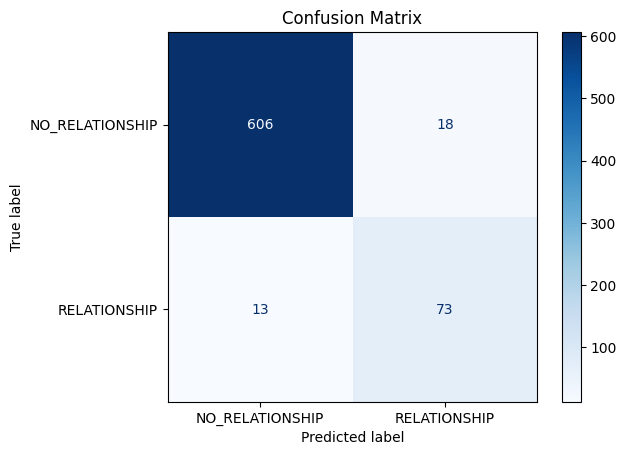

In [73]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["NO_RELATIONSHIP", "RELATIONSHIP"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [132]:
df_test = df_test.reset_index(drop=True)

# Add predictions to test set
df_test["true_label"] = true_labels
df_test["pred_label"] = pred_labels
df_test["prob_rel"] = pred_probs[:, 1]  # class 1 = RELATIONSHIP

In [69]:
print(false_positives.sort_values("prob_rel", ascending=False)[["sentence", "prob_rel"]])

                                              sentence  prob_rel
255  They had walked four or five abreast, and cons...  0.998084
610  They had walked four or five abreast, and cons...  0.998084
117  These natives were armed with an enormous numb...  0.997006
247  Alec and I had come to the camp just before th...  0.996299
393  It is next to impossible to make an old fool o...  0.995897
317  The residents of the Blinman invited Alec Ross...  0.995669
394  It was but poor consolation to tell him, what ...  0.994521
219  We did not return to the scene of our fight an...  0.994098
537  At this dam we were 160 miles from Eucla Harbo...  0.993372
336  Strange to say, we were not troubled here with...  0.987203
619  So I said, 'Well, now, Saleh, you say the moon...  0.985330
716  Alec, Jimmy, and I reached the bay on the 14th...  0.984090
702  I concluded-it may be said uncharitably, but t...  0.910914
532  I asked him had he seen Gibson, and to give me...  0.909773


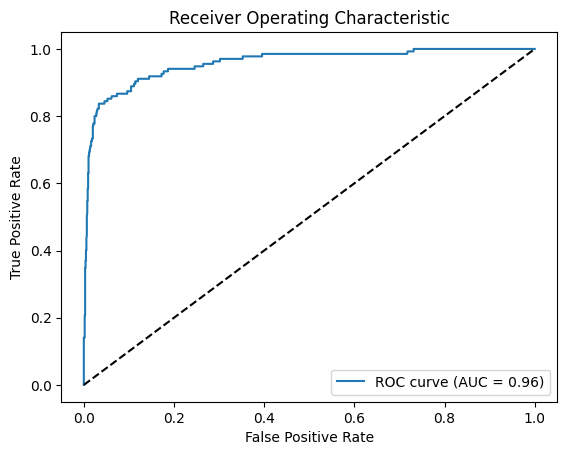

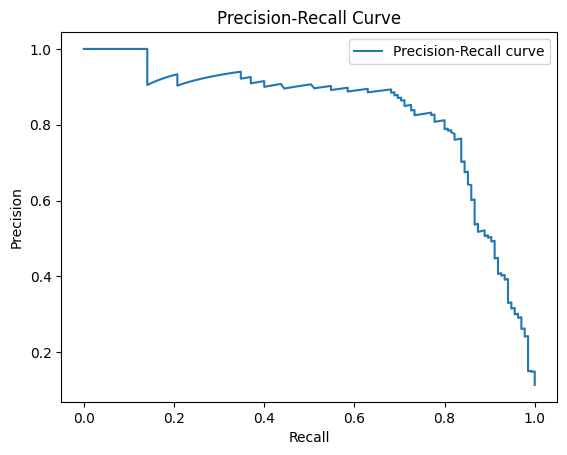

In [133]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# ROC
fpr, tpr, _ = roc_curve(true_labels, pred_probs[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend()
plt.show()

# Precision-Recall
precision, recall, _ = precision_recall_curve(true_labels, pred_probs[:, 1])

plt.figure()
plt.plot(recall, precision, label="Precision-Recall curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()


## Check Embeddings for FP

In [134]:
model = trainer.model  # ✅ already trained and restored with best weights
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [135]:
def get_cls_embedding(sentence):
    inputs = tokenizer(sentence, return_tensors="pt", truncation=True, max_length=512)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}  # ✅ Move to correct device

    with torch.no_grad():
        outputs = model.bert(**inputs)  # or model.roberta if you're using RoBERTa
    return outputs.last_hidden_state[0, 0].cpu().numpy()  # ✅ Move back to CPU for numpy


In [136]:
false_positives = df_test[(df_test["true_label"] == 0) & (df_test["pred_label"] == 1)].head(30)
false_negatives = df_test[(df_test["true_label"] == 1) & (df_test["pred_label"] == 0)].head(30)
true_positives  = df_test[(df_test["true_label"] == 1) & (df_test["pred_label"] == 1)].head(30)
true_negatives  = df_test[(df_test["true_label"] == 0) & (df_test["pred_label"] == 0)].head(30)


sent_fp = false_positives["sentence"].tolist()
sent_tp = true_positives["sentence"].tolist()
sent_tn = true_negatives["sentence"].tolist()
sent_fn = false_negatives["sentence"].tolist()

In [137]:
emb_fp = [get_cls_embedding(s) for s in sent_fp]
emb_tp = [get_cls_embedding(s) for s in sent_tp]
emb_tn = [get_cls_embedding(s) for s in sent_tn]
emb_fn = [get_cls_embedding(s) for s in sent_fn]

In [138]:
X = emb_fp + emb_tp + emb_tn + emb_fn
labels = (["False Positive"] * len(emb_fp) +
          ["True Relationship"] * len(emb_tp) +
          ["True Non-Relationship"] * len(emb_tn) + 
          ["False Negative"] * len(emb_fn)
         )

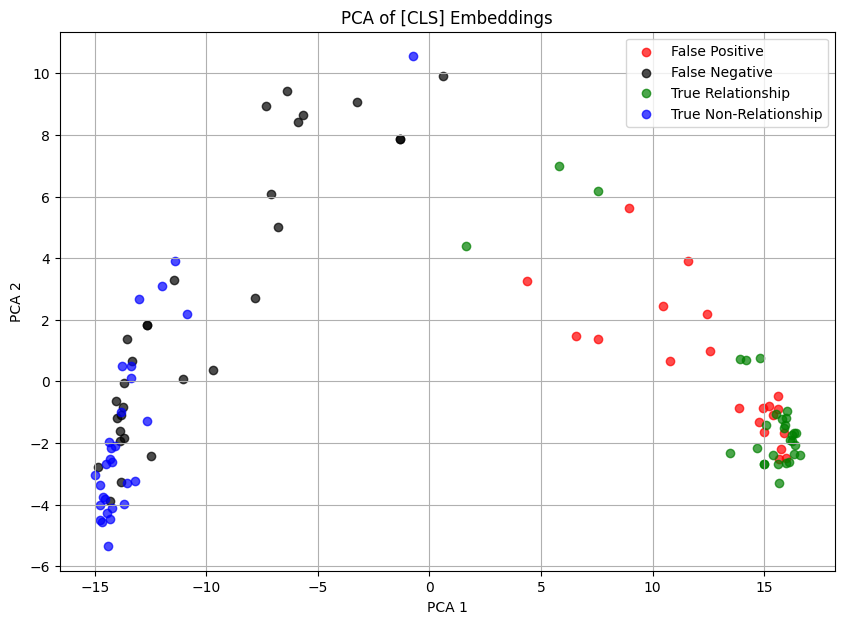

In [139]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

X_2d = PCA(n_components=2).fit_transform(X)

plt.figure(figsize=(10, 7))
colors = {"False Positive": "red", "True Relationship": "green", "True Non-Relationship": "blue", "False Negative": "black"}

for label in set(labels):
    idxs = [i for i, l in enumerate(labels) if l == label]
    plt.scatter(X_2d[idxs, 0], X_2d[idxs, 1], label=label, alpha=0.7, c=colors[label])

plt.legend()
plt.title("PCA of [CLS] Embeddings")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.show()

In [140]:
sent_fp

['Several of these girls declared their intention of coming with us.',
 "Jimmy Fitz, Perkins, Billy the black boy, and I, had just begun to eat when we heard a shot from Verney's revolver.",
 "I decided to leave the boy where he was, go after the horses, and then return with them to my last night's camp, and give the boy back to his father.",
 'On the 4th we found a clay-pan, having a clay-hole at one end with some mud in it, and which the natives had but just left, but no water; then another, where, as thunderstorms were flying about in all directions, we dug out a clay tank.',
 'This I cut off and threw away, much to the horror of the elders of his tribe, who, if they could catch, would inflict condign punishment upon him.',
 '\\"I have stated that when I went south with Alec Ross to Fowler\'s Bay I despatched my two officers, Mr. Tietkens and Mr. Young, with my black boy Tommy, to endeavour to discover a new depot to the north, at or as near to the 29th parallel of latitude as possi

## Grid Search

In [76]:
# Already set up earlier with CustomTrainer and `compute_metrics`
# Define a model_init function
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score


def model_init():
    return BertForSequenceClassification.from_pretrained(
        "bert-base-uncased", num_labels=2
    )

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    return {
        "eval_accuracy": accuracy_score(labels, preds),
        "eval_precision_macro": precision_score(labels, preds, average="macro", zero_division=0),
        "eval_recall_macro": recall_score(labels, preds, average="macro", zero_division=0),
        "eval_f1_macro": f1_score(labels, preds, average="macro", zero_division=0),
    }

# Define the hyperparameter space function that uses the trial object
def optuna_hp_space(trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate", 1e-5, 5e-5, log=True),
        "num_train_epochs": trial.suggest_int("num_train_epochs", 3, 6),
        "weight_decay": trial.suggest_float("weight_decay", 0.0, 0.3),
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [8, 16]),
    }

def compute_objective(metrics):
    return metrics["eval_precision_macro"] 

training_args = TrainingArguments(
    output_dir="./results",                 # Folder to save checkpoints and logs
    num_train_epochs=4,                     # Number of full passes through the training set
    per_device_train_batch_size=16,         # Batch size per GPU/CPU for training
    eval_strategy=IntervalStrategy.EPOCH,            # Run evaluation after each training epoch
    save_strategy=IntervalStrategy.EPOCH,                  # Save model checkpoint after each epoch
    logging_dir=None,                   # Directory for storing logs (TensorBoard, etc.)
    logging_steps=10,                       # Log metrics every 10 steps (if logging_strategy="steps")
    load_best_model_at_end=True,            # Restore the best model (lowest eval loss) at the end
    metric_for_best_model="eval_precision_macro",      # Metric to monitor for choosing the best model
    save_total_limit =1, 
    greater_is_better=True, 
    report_to = "none"
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [41]:
# pip install optuna

In [42]:
trainer = CustomTrainer(
    model_init=model_init,                     # <—— pass it here
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    compute_metrics=compute_metrics,
)


best_run = trainer.hyperparameter_search(
    hp_space=optuna_hp_space,
    compute_objective=compute_objective,
    direction="maximize",
    n_trials=10,
)

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-06-09 17:20:08,443] A new study created in memory with name: no-name-ee4eab27-fd38-4521-bfb2-bec1eb86b1cb
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN thi

Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro
1,0.503400,0.295950,0.898592,0.769667,0.907603,0.814525
2,0.200600,0.435929,0.949296,0.887665,0.872216,0.879718
3,0.282700,0.522442,0.949296,0.884800,0.877161,0.880926
4,0.057200,0.527400,0.947887,0.880124,0.876358,0.878228


/tmp/ipykernel_310235/3582064297.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_weights = torch.tensor(weights, device=logits.device)  # e.g., [no_rel, rel]
/tmp/ipykernel_310235/3582064297.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_weights = torch.tensor(weights, device=logits.device)  # e.g., [no_rel, rel]
/tmp/ipykernel_310235/3582064297.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_weights = torch.tensor(weights, device=logits.device)  # e.g., [no_rel, rel]
/tmp/ipykernel_310235/3582064297.py:4

Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro
1,0.712100,0.426167,0.943662,0.879717,0.849228,0.863569
2,0.178800,0.520960,0.943662,0.874022,0.859117,0.866353
3,0.389200,0.553617,0.946479,0.873148,0.880500,0.876772
4,0.128300,0.661700,0.949296,0.884800,0.877161,0.880926


/tmp/ipykernel_310235/3582064297.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_weights = torch.tensor(weights, device=logits.device)  # e.g., [no_rel, rel]
/tmp/ipykernel_310235/3582064297.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_weights = torch.tensor(weights, device=logits.device)  # e.g., [no_rel, rel]
/tmp/ipykernel_310235/3582064297.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_weights = torch.tensor(weights, device=logits.device)  # e.g., [no_rel, rel]
/tmp/ipykernel_310235/3582064297.py:4

Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro
1,0.401600,0.346302,0.839437,0.705894,0.868951,0.740790
2,0.182900,0.428458,0.943662,0.869006,0.869006,0.869006
3,0.286500,0.460781,0.949296,0.874941,0.896939,0.885484
4,0.117400,0.602790,0.946479,0.878118,0.870611,0.874311
5,0.149600,0.579072,0.943662,0.866725,0.873951,0.870286
6,0.044900,0.596859,0.945070,0.871090,0.874753,0.872909


/tmp/ipykernel_310235/3582064297.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_weights = torch.tensor(weights, device=logits.device)  # e.g., [no_rel, rel]
/tmp/ipykernel_310235/3582064297.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_weights = torch.tensor(weights, device=logits.device)  # e.g., [no_rel, rel]
/tmp/ipykernel_310235/3582064297.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_weights = torch.tensor(weights, device=logits.device)  # e.g., [no_rel, rel]
/tmp/ipykernel_310235/3582064297.py:4

Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro
1,0.518700,0.321626,0.936620,0.839410,0.894661,0.863891
2,0.026500,0.524772,0.956338,0.921894,0.866340,0.891415
3,0.486100,0.600556,0.946479,0.873148,0.880500,0.876772
4,0.177600,0.675531,0.952113,0.894487,0.878766,0.886400
5,0.222500,0.660110,0.953521,0.896337,0.884513,0.890298


/tmp/ipykernel_310235/3582064297.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_weights = torch.tensor(weights, device=logits.device)  # e.g., [no_rel, rel]
/tmp/ipykernel_310235/3582064297.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_weights = torch.tensor(weights, device=logits.device)  # e.g., [no_rel, rel]
/tmp/ipykernel_310235/3582064297.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_weights = torch.tensor(weights, device=logits.device)  # e.g., [no_rel, rel]
/tmp/ipykernel_310235/3582064297.py:4

Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro
1,0.565900,0.294508,0.894366,0.762324,0.890362,0.804758
2,0.243300,0.475070,0.949296,0.887665,0.872216,0.879718
3,0.257600,0.506953,0.949296,0.882105,0.882105,0.882105
4,0.052900,0.548077,0.949296,0.884800,0.877161,0.880926


/tmp/ipykernel_310235/3582064297.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_weights = torch.tensor(weights, device=logits.device)  # e.g., [no_rel, rel]
/tmp/ipykernel_310235/3582064297.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_weights = torch.tensor(weights, device=logits.device)  # e.g., [no_rel, rel]
/tmp/ipykernel_310235/3582064297.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_weights = torch.tensor(weights, device=logits.device)  # e.g., [no_rel, rel]
/tmp/ipykernel_310235/3582064297.py:4

Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro
1,0.569500,0.388367,0.942254,0.866894,0.863259,0.865063


[I 2025-06-09 17:39:10,111] Trial 5 pruned. 
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_310235/3582064297.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_weights = torch.tensor(weights, device=logits.device)  # e.g., [no_rel, rel]


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro
1,0.437400,0.312390,0.885915,0.750522,0.880602,0.792061


[I 2025-06-09 17:39:52,150] Trial 6 pruned. 
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_310235/3582064297.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_weights = torch.tensor(weights, device=logits.device)  # e.g., [no_rel, rel]


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro
1,0.402900,0.280618,0.857746,0.723355,0.884329,0.762941


[I 2025-06-09 17:40:33,929] Trial 7 pruned. 
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_310235/3582064297.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_weights = torch.tensor(weights, device=logits.device)  # e.g., [no_rel, rel]


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro
1,0.584700,0.331143,0.956338,0.903088,0.891063,0.896947
2,0.007600,0.503843,0.960563,0.926551,0.883581,0.903488
3,0.219900,0.570770,0.953521,0.906463,0.869680,0.886853


/tmp/ipykernel_310235/3582064297.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_weights = torch.tensor(weights, device=logits.device)  # e.g., [no_rel, rel]
/tmp/ipykernel_310235/3582064297.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_weights = torch.tensor(weights, device=logits.device)  # e.g., [no_rel, rel]
/tmp/ipykernel_310235/3582064297.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_weights = torch.tensor(weights, device=logits.device)  # e.g., [no_rel, rel]
[W 2025-06-09 17:42:58,186] Trial 8 f

RuntimeError: File ./results/run-8/checkpoint-1242/optimizer.pt cannot be opened.

In [46]:
import os
import re
from transformers import BertForSequenceClassification, Trainer

# Set your metric
metric_to_use = "eval_precision_macro"

# Define base path for all runs
base_path = "./results"

best_score = -1
best_run = None

# Loop over run-* folders
for run_dir in sorted(os.listdir(base_path)):
    run_path = os.path.join(base_path, run_dir)
    if os.path.isdir(run_path) and re.match(r"run-\d+", run_dir):
        try:
            # Find latest checkpoint-* folder inside run_dir
            checkpoints = [f for f in os.listdir(run_path) if f.startswith("checkpoint-")]
            if not checkpoints:
                continue
            latest_ckpt = sorted(checkpoints, key=lambda x: int(x.split("-")[-1]))[-1]
            model_path = os.path.join(run_path, latest_ckpt)

            # Load model and evaluate
            model = BertForSequenceClassification.from_pretrained(model_path)
            trainer.model = model.to(trainer.args.device)
            metrics = trainer.evaluate(eval_dataset=val_ds)

            score = metrics.get(metric_to_use)
            print(f"{run_dir}/{latest_ckpt} → {metric_to_use}: {score:.4f}")

            if score is not None and score > best_score:
                best_score = score
                best_run = model_path

        except Exception as e:
            print(f"⚠️ Skipping {run_dir}: {e}")

print(f"\n🏆 Best checkpoint: {best_run} with {metric_to_use}: {best_score:.4f}")

/tmp/ipykernel_310235/3582064297.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_weights = torch.tensor(weights, device=logits.device)  # e.g., [no_rel, rel]


run-0/checkpoint-414 → eval_precision_macro: 0.8877


/tmp/ipykernel_310235/3582064297.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_weights = torch.tensor(weights, device=logits.device)  # e.g., [no_rel, rel]


run-1/checkpoint-1656 → eval_precision_macro: 0.8848


/tmp/ipykernel_310235/3582064297.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_weights = torch.tensor(weights, device=logits.device)  # e.g., [no_rel, rel]


run-2/checkpoint-828 → eval_precision_macro: 0.8781


/tmp/ipykernel_310235/3582064297.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_weights = torch.tensor(weights, device=logits.device)  # e.g., [no_rel, rel]


run-3/checkpoint-828 → eval_precision_macro: 0.9219


/tmp/ipykernel_310235/3582064297.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_weights = torch.tensor(weights, device=logits.device)  # e.g., [no_rel, rel]


run-4/checkpoint-414 → eval_precision_macro: 0.8877


/tmp/ipykernel_310235/3582064297.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_weights = torch.tensor(weights, device=logits.device)  # e.g., [no_rel, rel]


run-8/checkpoint-1242 → eval_precision_macro: 0.9065

🏆 Best checkpoint: ./results/run-3/checkpoint-828 with eval_precision_macro: 0.9219


In [50]:
best_run = trainer.hyperparameter_search(
    hp_space=optuna_hp_space,
    compute_objective=compute_objective,
    direction="maximize",
    n_trials=0  # reruns nothing, just loads previous if cached
)
print(best_run.hyperparameters)

[I 2025-06-09 18:19:19,604] A new study created in memory with name: no-name-85ce146b-8d1b-4be7-bde4-f6afa16892f3


ValueError: No trials are completed yet.

In [77]:
best_params = {
    "learning_rate": 1.5995587725606377e-5,
    "num_train_epochs": 5,
    "per_device_train_batch_size": 8,
    "weight_decay": 0.0934777353160356
}

In [78]:
# from transformers import TrainingArguments

# best_params = best_run.hyperparameters

training_args = TrainingArguments(
    output_dir="./best-results",                             # you can change this
    num_train_epochs=best_params["num_train_epochs"],
    per_device_train_batch_size=best_params["per_device_train_batch_size"],
    eval_strategy=IntervalStrategy.EPOCH,            # Run evaluation after each training epoch
    save_strategy=IntervalStrategy.EPOCH,                  # Save model checkpoint after each epoch
    logging_dir="./logs",
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="eval_precision_macro",
    weight_decay=best_params["weight_decay"],
    learning_rate=best_params["learning_rate"],
    save_total_limit=1, 
    report_to="none"                                         # turn off wandb if needed
)

model = BertForSequenceClassification.from_pretrained(
    "./results/run-3/checkpoint-828"
)

trainer = CustomTrainer(
    model= model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    compute_metrics=compute_metrics
)

trainer.train()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


RuntimeError: false INTERNAL ASSERT FAILED at "../c10/cuda/CUDAGraphsC10Utils.h":73, please report a bug to PyTorch. Unknown CUDA graph CaptureStatus21904

In [64]:
eval_results = trainer.evaluate(eval_dataset=test_ds)
print(eval_results)

/tmp/ipykernel_310235/3582064297.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_weights = torch.tensor(weights, device=logits.device)  # e.g., [no_rel, rel]


{'eval_accuracy': 0.9577464788732394, 'eval_precision_macro': 0.8876900108577632, 'eval_recall_macro': 0.925834824090638, 'eval_f1_macro': 0.9054661009426761, 'eval_loss': 0.29549819231033325, 'eval_runtime': 2.8395, 'eval_samples_per_second': 250.042, 'eval_steps_per_second': 31.343, 'epoch': 3.0}


In [54]:
# Save final model
trainer.save_model("./best-relationship-strict-bert")
tokenizer.save_pretrained("./best-relationship-strict-bert")

('./best-relationship-strict-bert/tokenizer_config.json',
 './best-relationship-strict-bert/special_tokens_map.json',
 './best-relationship-strict-bert/vocab.txt',
 './best-relationship-strict-bert/added_tokens.json')

In [166]:
import shutil
from google.colab import files  # only in Colab

# Zip the model directory
shutil.make_archive("best-sentiment-bert", "zip", "best-sentiment-bert")

# Download the zip file
files.download("best-sentiment-bert.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## With RoBERTA

In [80]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [81]:
model_name = "roberta-base"

In [82]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [83]:
true_max_length = max([len(s.split()) for s in df_train['sentence']]) 

if true_max_length > 512:
    print(f"max length exceed 512 at {true_max_length}")
    true_max_length = 512
    
print(f"For submission, max_length is :{true_max_length}")
def tokenize_function(example):
    return tokenizer(example["sentence"], padding="max_length", truncation=True, max_length=true_max_length)

For submission, max_length is :390


In [84]:
# Convert to HuggingFace datasets
train_ds = Dataset.from_pandas(df_train)
val_ds = Dataset.from_pandas(df_val)
test_ds = Dataset.from_pandas(df_test)

train_ds = train_ds.map(tokenize_function, batched=True)
val_ds = val_ds.map(tokenize_function, batched=True)
test_ds = test_ds.map(tokenize_function, batched=True)

# train_ds.set_format(type = 'torch', columns = ['input_ids', 'attention_mask', 'label'])
# val_ds.set_format(type = 'torch', columns = ['input_ids', 'attention_mask', 'label'])
# test_ds.set_format(type = 'torch', columns = ['input_ids', 'attention_mask', 'label'])

Map: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 710/710 [00:00<00:00, 7567.64 examples/s]


In [85]:
training_args = TrainingArguments(
    output_dir="./roberta-results",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    eval_strategy=IntervalStrategy.EPOCH,            # Run evaluation after each training epoch
    save_strategy=IntervalStrategy.EPOCH,                  # Save model checkpoint after each epoch
    logging_dir=None,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="eval_precision_macro",
    learning_rate=2e-5,
    weight_decay=0.1,
    save_total_limit=1, 
    report_to="none"                                         # turn off wandb if needed
)

# STEP 3: Reinitialize trainer with best config
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    compute_metrics=compute_metrics
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


RuntimeError: false INTERNAL ASSERT FAILED at "../c10/cuda/CUDAGraphsC10Utils.h":73, please report a bug to PyTorch. Unknown CUDA graph CaptureStatus21904

In [62]:
trainer.train()

/tmp/ipykernel_310235/3582064297.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_weights = torch.tensor(weights, device=logits.device)  # e.g., [no_rel, rel]


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro
1,0.544400,0.316931,0.888732,0.754833,0.887152,0.797195
2,0.331100,0.448931,0.945070,0.864673,0.889587,0.876527
3,0.386000,0.493772,0.939437,0.854193,0.871543,0.862564


/tmp/ipykernel_310235/3582064297.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_weights = torch.tensor(weights, device=logits.device)  # e.g., [no_rel, rel]
/tmp/ipykernel_310235/3582064297.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_weights = torch.tensor(weights, device=logits.device)  # e.g., [no_rel, rel]
/tmp/ipykernel_310235/3582064297.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_weights = torch.tensor(weights, device=logits.device)  # e.g., [no_rel, rel]


TrainOutput(global_step=621, training_loss=0.3560558910243177, metrics={'train_runtime': 138.2921, 'train_samples_per_second': 71.826, 'train_steps_per_second': 4.49, 'total_flos': 1990738328178600.0, 'train_loss': 0.3560558910243177, 'epoch': 3.0})

In [63]:
trainer.evaluate(eval_dataset=test_ds)

/tmp/ipykernel_310235/3582064297.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_weights = torch.tensor(weights, device=logits.device)  # e.g., [no_rel, rel]


{'eval_accuracy': 0.9577464788732394,
 'eval_precision_macro': 0.8876900108577632,
 'eval_recall_macro': 0.925834824090638,
 'eval_f1_macro': 0.9054661009426761,
 'eval_loss': 0.29549819231033325,
 'eval_runtime': 2.7418,
 'eval_samples_per_second': 258.953,
 'eval_steps_per_second': 32.46,
 'epoch': 3.0}

In [79]:
trainer.save_model("./best-relationship-strict-roberta")
tokenizer.save_pretrained("./best-relationship-strict-roberta")

('./best-relationship-strict-roberta/tokenizer_config.json',
 './best-relationship-strict-roberta/special_tokens_map.json',
 './best-relationship-strict-roberta/vocab.txt',
 './best-relationship-strict-roberta/added_tokens.json')

# Train on Full data set

In [17]:
from datasets import concatenate_datasets

full_ds = concatenate_datasets([train_ds, val_ds, test_ds])

In [18]:
best_params = {
    "learning_rate": 1.6e-5,
    "num_train_epochs": 5,
    "per_device_train_batch_size": 8,
    "weight_decay": 0.0935
}


In [21]:
from transformers import TrainingArguments

final_training_args = TrainingArguments(
    output_dir="./final-model",
    num_train_epochs=best_params["num_train_epochs"],
    per_device_train_batch_size=best_params["per_device_train_batch_size"],
    evaluation_strategy="no",  # No eval during final training
    save_strategy=IntervalStrategy.EPOCH,
    logging_dir="./logs",
    logging_steps=10,
    weight_decay=best_params["weight_decay"],
    learning_rate=best_params["learning_rate"],
    save_total_limit=1,
    report_to="none"
)

/cluster/home/hlee37/condaenv/torch_env/lib/python3.8/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [22]:
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained("./results/run-3/checkpoint-828")

In [23]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=final_training_args,
    train_dataset=full_ds
)

trainer.train()

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss
10,0.129600
20,0.157600
30,0.256600
40,0.298500
50,0.127100
60,0.265800
70,0.156100
80,0.164400
90,0.024500
100,0.288000


TrainOutput(global_step=2960, training_loss=0.0955247511344685, metrics={'train_runtime': 328.5369, 'train_samples_per_second': 72.001, 'train_steps_per_second': 9.01, 'total_flos': 4740855245451000.0, 'train_loss': 0.0955247511344685, 'epoch': 5.0})

In [24]:
model.save_pretrained("./final-model")
tokenizer.save_pretrained("./final-model")

('./final-model/tokenizer_config.json',
 './final-model/special_tokens_map.json',
 './final-model/vocab.txt',
 './final-model/added_tokens.json')

## Zero-Shot with BERT (deprecated due to low performance)

In [ ]:
results = []

for sent in sample_sentences:
    pred = classifier(sent, candidate_labels)
    label = pred['labels'][0]
    score = pred['scores'][0]
    results.append({'sentence': sent,
                    'score': score
                    })

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [ ]:
df = pd.DataFrame(results)
df = df.sort_values(by='score', ascending=False)

# Preview top hits
print(df.head())


                                              sentence     score
991  It was singular how we should have dropped upo...  0.984266
992  Here our native escort was increased by the ar...  0.979711
103  On the evening of the third day after leaving ...  0.975902
191  In about twelve miles Alec Ross and Tommy foun...  0.973501
914                              Natives accompany us.  0.971435


In [ ]:
pd.set_option('display.max_colwidth', None)

In [ ]:
print(df.head())

                                                                                                                                                                                                                                         sentence  \
991                                                                       It was singular how we should have dropped upon such a scene, and penetrated thus the desert's vastness, to the scrub-secluded fastness of these Austral-Indians' home.   
992  Here our native escort was increased by the arrival of a young black gentleman, most beautifully dressed in fat and red ochre, with many extraordinary white marks or figures all over his back; we were informed that he was a "cowra man."   
103                  On the evening of the third day after leaving the water that had saved us, we fell in with two black fellows and their lubras or wives, shepherding two flocks of Mr. Angas's sheep belonging to his Stuart's Creek station.   
191                 

In [ ]:
print(df.tail())

                                                                                                                           sentence  \
736                                                                                                                            Soc.   
13                                                                                                      Barren and wretched region.   
963  What with the position I was in and the horrible odour which rose from the seething fluid, I was seized with violent retching.   
306                                                                                                            Find a small supply.   
589                       Fortunately the day had been remarkably cool, almost cold, the thermometer only rose to 80° in the shade.   

        score  
736  0.501092  
13   0.500980  
963  0.500580  
306  0.500440  
589  0.500431  


In [ ]:
df_pos = df[df['score'] > 0.9]

In [ ]:
df_pos.head(20)

,sentence,score
991,"It was singular how we should have dropped upon such a scene, and penetrated thus the desert's vastness, to the scrub-secluded fastness of these Austral-Indians' home.",0.984266
992,"Here our native escort was increased by the arrival of a young black gentleman, most beautifully dressed in fat and red ochre, with many extraordinary white marks or figures all over his back; we were informed that he was a ""cowra man.""",0.979711
103,"On the evening of the third day after leaving the water that had saved us, we fell in with two black fellows and their lubras or wives, shepherding two flocks of Mr. Angas's sheep belonging to his Stuart's Creek station.",0.975902
191,In about twelve miles Alec Ross and Tommy found a place where the natives had formerly obtained water by digging.,0.973501
914,Natives accompany us.,0.971435
834,From their farthest westerly point in latitude 28° 59´ they turned upon a bearing of south 55° east direct for the native well found near the little flat-topped hills before mentioned.,0.970258
9,"Two of its native lords visited the camp this morning, and did not appear at all inclined to leave it.",0.970089
453,"I was desirous, as were they, that my two officers should share the honour of completing a line of discovery from Youldeh, northwards to the Everard and Musgrave Ranges, and thus connect those considerable geographical features with the coast-line at Fowler's Bay; and I promised them if they were fortunate and discovered more water for a depot to the north, that they should finish their line, whether I was successful to the west or not.",0.966293
367,"Our latitude here was 26° 14´ 50´´.Immediately upon arrival, our cowra man and his friend seemed aware of the presence of other natives in the neighbourhood, and began to make signal smokes to induce their countrymen to approach.",0.962880
31,"But it was only an instance of one of Nature's freaks, in which she had so successfully imitated her imitator, Art.",0.960395


In [ ]:
# Save to CSV
# df.to_csv("book1_relationship_sentences.csv", index=False)